In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline
from time import time

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from plotly.offline import init_notebook_mode

py.sign_in('imaginationsuper', 'PQj7gXzsTJFqNKsXkWMT')
init_notebook_mode(connected=True)

In [2]:
def universe_partition(data, d1=10, d2=10):
    x_max, x_min = data.max(axis=0), data.min(axis=0)
    std_val = data.std(axis=0)
    len_val = np.round(std_val / 50)
    u_max, u_min = int(x_max+d2), int(x_min-d1) # bound of universe discourse
    u_b = np.arange(u_min, u_max, step=float(len_val)) # cutting points
    u_s = u_b[:-1] # u1
    u_e = u_b[1:] # u2
    u_discourse = zip(u_b, u_e) # interval
    return u_discourse

def set_fuzzy_numbers(u_discourse):
    fuzzy_numbers = list()
    for i, u_i in enumerate(u_discourse):
        if (i!=0) and (i!=len(u_discourse)-1):
            u_l, u_r = u_discourse[i-1], u_discourse[i+1]
            A_l, A_r = np.mean(u_l), np.mean(u_r)
            fuzzy_numbers.append((A_l, u_i[0], u_i[1], A_r))
    return fuzzy_numbers

In [3]:
def membership_evaluation(value, fuzzy_number):
    A_l, u_1, u_2, A_r = fuzzy_number
    mu = 0 # membership indication
    try:
        if np.logical_and(value>=A_l, value <u_1):
            mu = (value - A_l) / (u_1 - A_l)
        elif np.logical_and(value>=u_1, value<=u_2):
            mu = 1
        elif np.logical_and(value>u_2, value<=A_r):
            mu = (value - u_2) / (A_r - u_2)
    except ZeroDivisionError:
        mu = 0
    return mu

def membership_assignement(value_time_series, fuzzy_numbers):
    n_fuzzy_numbers = len(fuzzy_numbers)
    membership_list = list()
    for i, value in enumerate(value_time_series):
        value_rep = [value] * n_fuzzy_numbers
        memberships = map(lambda val, A: membership_evaluation(val, A), value_rep, fuzzy_numbers)
        max_index, _ = max(enumerate(memberships), key=operator.itemgetter(1))
        membership_list.append(max_index)
    return membership_list

def get_membership(value, fuzzy_numbers):
    n_fuzzy_numbers = len(fuzzy_numbers)
    membership_index = 0
    value_rep = [value] * n_fuzzy_numbers
    memberships = map(lambda val, Ai: membership_evaluation(val, Ai), value_rep, fuzzy_numbers)
    membership_index, _ = max(enumerate(memberships), key=operator.itemgetter(1))
    return membership_index

In [4]:
def FLR(membership_time_series): # transition between consecutive observations
    transitions = list()
    for j, Aj in enumerate(membership_time_series):
        if j!=0:
            Ai = membership_time_series[j-1]
            transitions.append((Ai, Aj))
    return transitions

def FLR_weight(transitions, time_series): # compute jump frequency by FLR
    jumps = map(lambda x: x[1]-x[0], transitions) # compute jumps by transitions 
    jump_time_series = zip(jumps, time_series) # assign timestamp for each jump beta^t_p,p+k
    jump_counts = defaultdict(list) 
    for key, value in jump_time_series:
        jump_counts[key].append(value) # count jump by its timestamps
    jump_counts = {key: np.sum(value) for key, value in jump_counts.items()} # sum up total time for each jump
    total_count = float(np.sum(jump_counts.values()))
    for key, value in jump_counts.iteritems(): 
        jump_counts[key] = value / total_count # normalize jumps as weights
    return jump_counts

def FRG_weight(transitions, time_series): 
    transition_time_series = zip(transitions, time_series)
    transition_groups = map(lambda x: (x[0][0], (x[0][1], x[1])), transition_time_series) 
    transition_weights = defaultdict(list)
    for key, value in transition_groups:
        transition_weights[key].append(value) # group transitions by initial state A_i
    transition_weights = {key: dict(value) for key, value in transition_weights.items()}
    for key, value in transition_weights.iteritems():
        total_weight = float(np.sum(value.values()))
        value = {k: (v/total_weight) for k, v in value.items()} # normalize weight inside each group
        transition_weights[key] = value
    return transition_weights

In [5]:
# forecasting by fuzzy numbers
def fuzzy_add(A, B): # Proposition #1 (1)
    return tuple([np.sum(x) for x in zip(A, B)])

def fuzzy_scale(c, A): # Proposition #1 (2)
    cA = [c*a for a in A]
    if c>=0:
        return tuple(cA)
    else:
        cA.reverse()
        return tuple(cA)

def forecast_jump(i, s, A_list):
    jumps = s.keys() # possible jumps
    m = len(A_list) # number of fuzzy numbers in model
    sA_list = list()
    sk_list = list()
    Aip_list = list()
    sA = tuple([0]*len(A_list[0]))
    for k in jumps:
        ip = k+i
        if (ip>=0 and ip<m): # check if index is within range
            sk_list.append(s[k])
            Aip_list.append(A_list[ip])
    sk_tot = np.sum(sk_list)
    sk_list = [sk/float(sk_tot) for sk in sk_list] # normalize locally
    for i in range(len(sk_list)):
        sA_list.append(fuzzy_scale(sk_list[i], Aip_list[i]))
    if len(sA_list)>0:
        for sa in sA_list:
            sA = fuzzy_add(sA, sa)
    return sA
    
def forecast_transition(i, w, A_list):
    wA = tuple([0]*len(A_list[0])) # default FLG relation
    if i in w.keys():
        for kj, v in w[i].iteritems():
            wA = fuzzy_add(wA, fuzzy_scale(v, A_list[kj]))
    return wA

def forecast_price(As, Aw, gamma=0.1):
    if gamma<0 or gamma>1:
        raise ValueError("gamma should be between 0.0 and 1.0 (inclusive on both ends)")     
    wAi = fuzzy_scale(1-gamma, Aw)
    if (np.sum(wAi) == 0): # no FLR observed in history
        sAi = As
    else:
        sAi = fuzzy_scale(gamma, As)
    Ai_pred = fuzzy_add(sAi, wAi)
    return np.mean(Ai_pred)

In [6]:
start_time = time()
datafile = '../data/IBEX35(201301-201512).xlsx'
xl = pd.ExcelFile(datafile)
df = xl.parse(u'Sheet1')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2013-01-02,8447.6,8337.9,8447.6,8286.7,280.53M,0.0343
1,2013-01-03,8403.4,8375.0,8422.6,8334.3,182.28M,-0.0052
2,2013-01-04,8435.8,8411.7,8447.0,8386.7,230.12M,0.0039
3,2013-01-07,8419.0,8434.3,8485.6,8406.3,289.12M,-0.0020
4,2013-01-08,8453.0,8388.2,8493.5,8374.7,335.52M,0.0040


In [7]:
df.describe()

,Price,Open,High,Low,Change %
count,792.000000,792.000000,792.000000,792.000000,792.000000
mean,9963.164141,9965.216667,10037.700379,9878.218687,0.000415
std,1040.412907,1042.242568,1042.808739,1037.357084,0.012150
min,7553.200000,7636.600000,7674.600000,7508.400000,-0.050100
25%,9348.350000,9334.300000,9416.875000,9264.625000,-0.006800
50%,10223.250000,10227.000000,10310.500000,10129.350000,0.001000
75%,10691.600000,10700.725000,10761.575000,10611.200000,0.007600
max,11866.400000,11798.500000,11884.600000,11760.800000,0.038700


In [8]:
split_date = '2014-12-31'
train_data = df[df['Date'] <= split_date]
test_data = df[df['Date'] > split_date]
print train_data.shape, test_data.shape

(557, 7) (235, 7)


In [9]:
u_discourse = universe_partition(train_data['Price'], d1=953, d2=812)
print(u_discourse)

[(6600.0, 6620.0), (6620.0, 6640.0), (6640.0, 6660.0), (6660.0, 6680.0), (6680.0, 6700.0), (6700.0, 6720.0), (6720.0, 6740.0), (6740.0, 6760.0), (6760.0, 6780.0), (6780.0, 6800.0), (6800.0, 6820.0), (6820.0, 6840.0), (6840.0, 6860.0), (6860.0, 6880.0), (6880.0, 6900.0), (6900.0, 6920.0), (6920.0, 6940.0), (6940.0, 6960.0), (6960.0, 6980.0), (6980.0, 7000.0), (7000.0, 7020.0), (7020.0, 7040.0), (7040.0, 7060.0), (7060.0, 7080.0), (7080.0, 7100.0), (7100.0, 7120.0), (7120.0, 7140.0), (7140.0, 7160.0), (7160.0, 7180.0), (7180.0, 7200.0), (7200.0, 7220.0), (7220.0, 7240.0), (7240.0, 7260.0), (7260.0, 7280.0), (7280.0, 7300.0), (7300.0, 7320.0), (7320.0, 7340.0), (7340.0, 7360.0), (7360.0, 7380.0), (7380.0, 7400.0), (7400.0, 7420.0), (7420.0, 7440.0), (7440.0, 7460.0), (7460.0, 7480.0), (7480.0, 7500.0), (7500.0, 7520.0), (7520.0, 7540.0), (7540.0, 7560.0), (7560.0, 7580.0), (7580.0, 7600.0), (7600.0, 7620.0), (7620.0, 7640.0), (7640.0, 7660.0), (7660.0, 7680.0), (7680.0, 7700.0), (7700.0, 

In [10]:
A_list = set_fuzzy_numbers(u_discourse)
print(A_list)

[(6610.0, 6620.0, 6640.0, 6650.0), (6630.0, 6640.0, 6660.0, 6670.0), (6650.0, 6660.0, 6680.0, 6690.0), (6670.0, 6680.0, 6700.0, 6710.0), (6690.0, 6700.0, 6720.0, 6730.0), (6710.0, 6720.0, 6740.0, 6750.0), (6730.0, 6740.0, 6760.0, 6770.0), (6750.0, 6760.0, 6780.0, 6790.0), (6770.0, 6780.0, 6800.0, 6810.0), (6790.0, 6800.0, 6820.0, 6830.0), (6810.0, 6820.0, 6840.0, 6850.0), (6830.0, 6840.0, 6860.0, 6870.0), (6850.0, 6860.0, 6880.0, 6890.0), (6870.0, 6880.0, 6900.0, 6910.0), (6890.0, 6900.0, 6920.0, 6930.0), (6910.0, 6920.0, 6940.0, 6950.0), (6930.0, 6940.0, 6960.0, 6970.0), (6950.0, 6960.0, 6980.0, 6990.0), (6970.0, 6980.0, 7000.0, 7010.0), (6990.0, 7000.0, 7020.0, 7030.0), (7010.0, 7020.0, 7040.0, 7050.0), (7030.0, 7040.0, 7060.0, 7070.0), (7050.0, 7060.0, 7080.0, 7090.0), (7070.0, 7080.0, 7100.0, 7110.0), (7090.0, 7100.0, 7120.0, 7130.0), (7110.0, 7120.0, 7140.0, 7150.0), (7130.0, 7140.0, 7160.0, 7170.0), (7150.0, 7160.0, 7180.0, 7190.0), (7170.0, 7180.0, 7200.0, 7210.0), (7190.0, 7200

In [11]:
train_data_membership_series = membership_assignement(train_data['Price'], fuzzy_numbers=A_list)
print (train_data_membership_series)

[91, 89, 90, 89, 91, 99, 99, 102, 100, 99, 98, 100, 99, 102, 100, 99, 102, 105, 102, 101, 97, 87, 80, 64, 73, 71, 69, 77, 72, 80, 84, 81, 76, 74, 80, 77, 69, 77, 81, 68, 75, 80, 78, 81, 90, 86, 88, 100, 96, 95, 93, 101, 99, 94, 85, 89, 86, 85, 76, 68, 64, 64, 71, 64, 61, 58, 58, 62, 75, 76, 71, 69, 66, 59, 59, 64, 70, 83, 88, 87, 83, 91, 89, 89, 96, 94, 96, 98, 97, 96, 91, 92, 98, 96, 98, 94, 92, 92, 86, 82, 87, 94, 91, 90, 85, 83, 87, 83, 79, 82, 80, 73, 75, 72, 72, 75, 78, 73, 60, 54, 46, 49, 60, 61, 57, 64, 63, 57, 69, 62, 69, 69, 68, 70, 61, 61, 58, 59, 66, 66, 67, 72, 78, 83, 86, 87, 91, 90, 96, 97, 97, 95, 97, 102, 105, 104, 106, 108, 105, 110, 101, 94, 92, 100, 103, 101, 88, 88, 90, 83, 90, 91, 93, 95, 101, 100, 109, 112, 115, 116, 118, 118, 122, 126, 127, 124, 127, 131, 132, 130, 128, 136, 135, 133, 140, 138, 134, 140, 152, 152, 153, 159, 162, 164, 169, 170, 169, 160, 164, 159, 155, 162, 157, 164, 160, 162, 158, 160, 156, 156, 158, 154, 152, 154, 153, 158, 150, 146, 148, 152, 1

In [12]:
transition_FLR = FLR(train_data_membership_series)
print(transition_FLR)

[(91, 89), (89, 90), (90, 89), (89, 91), (91, 99), (99, 99), (99, 102), (102, 100), (100, 99), (99, 98), (98, 100), (100, 99), (99, 102), (102, 100), (100, 99), (99, 102), (102, 105), (105, 102), (102, 101), (101, 97), (97, 87), (87, 80), (80, 64), (64, 73), (73, 71), (71, 69), (69, 77), (77, 72), (72, 80), (80, 84), (84, 81), (81, 76), (76, 74), (74, 80), (80, 77), (77, 69), (69, 77), (77, 81), (81, 68), (68, 75), (75, 80), (80, 78), (78, 81), (81, 90), (90, 86), (86, 88), (88, 100), (100, 96), (96, 95), (95, 93), (93, 101), (101, 99), (99, 94), (94, 85), (85, 89), (89, 86), (86, 85), (85, 76), (76, 68), (68, 64), (64, 64), (64, 71), (71, 64), (64, 61), (61, 58), (58, 58), (58, 62), (62, 75), (75, 76), (76, 71), (71, 69), (69, 66), (66, 59), (59, 59), (59, 64), (64, 70), (70, 83), (83, 88), (88, 87), (87, 83), (83, 91), (91, 89), (89, 89), (89, 96), (96, 94), (94, 96), (96, 98), (98, 97), (97, 96), (96, 91), (91, 92), (92, 98), (98, 96), (96, 98), (98, 94), (94, 92), (92, 92), (92, 86

In [13]:
first_date = train_data['Date'][0]
train_data_days = train_data['Date'].apply(lambda x: x-first_date).dt.days.tolist() # convert Timedelta to numeric days
train_data_days = [d+1 for d in train_data_days]
print train_data_days

[1, 2, 3, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 83, 84, 85, 86, 91, 92, 93, 94, 97, 98, 99, 100, 101, 104, 105, 106, 107, 108, 111, 112, 113, 114, 115, 118, 119, 121, 122, 125, 126, 127, 128, 129, 132, 133, 134, 135, 136, 139, 140, 141, 142, 143, 146, 147, 148, 149, 150, 153, 154, 155, 156, 157, 160, 161, 162, 163, 164, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 181, 182, 183, 184, 185, 188, 189, 190, 191, 192, 195, 196, 197, 198, 199, 202, 203, 204, 205, 206, 209, 210, 211, 212, 213, 216, 217, 218, 219, 220, 223, 224, 225, 226, 227, 230, 231, 232, 233, 234, 237, 238, 239, 240, 241, 244, 245, 246, 247, 248, 251, 252, 253, 254, 255, 258, 259, 260, 261, 262, 265, 266, 267, 268, 269, 272, 273, 274, 275, 276, 279, 280, 281, 282, 283, 286, 287, 288, 289, 290, 293, 294, 295, 296, 297, 300, 301, 302, 303, 304, 

In [14]:
jump_weights = FLR_weight(transition_FLR, train_data_days[:len(transition_FLR)])
print (jump_weights)

{0: 0.1830386678965186, 1: 0.087931192682703038, 2: 0.069106731507550548, 3: 0.041705501977582569, 4: 0.057048065639321778, 5: 0.033375025957280355, 6: 0.037919360992123473, 7: 0.033302587035364685, 8: 0.023513674053826948, 9: 0.010378082879785195, 10: 0.013575053966996826, 11: 0.0082290615296202758, 12: 0.0057275040927990883, 13: 0.003066581027763424, 14: 0.0049403344746487918, 15: 0.0033901415456534232, 16: 0.0033225318851987967, 17: 0.003452921944647005, -2: 0.054952166165228349, -19: 0.0050127733965644634, -17: 0.0064905274036441609, -16: 0.00014970710529238764, -14: 0.0034239463758807365, -13: 0.0056116018177340141, -12: 0.007876525442964008, -11: 0.011797885749332354, -10: 0.0074950137875414713, -9: 0.010281497650564299, -8: 0.021683383960090983, -7: 0.035519218045984229, -6: 0.022813431141975458, -5: 0.037441264107480041, -4: 0.041584770441056448, -3: 0.042159452554920776, -1: 0.06268381376436101}


In [15]:
transition_weights = FRG_weight(transition_FLR, train_data_days[:len(transition_FLR)])
print transition_weights

{46: {49: 1.0}, 49: {60: 1.0}, 54: {46: 1.0}, 57: {64: 0.4930747922437673, 69: 0.5069252077562327}, 58: {58: 0.24289405684754523, 59: 0.5064599483204134, 62: 0.25064599483204136}, 59: {64: 0.26097560975609757, 66: 0.48048780487804876, 59: 0.25853658536585367}, 60: {61: 0.5086705202312138, 54: 0.4913294797687861}, 61: {57: 0.31382978723404253, 58: 0.34574468085106386, 61: 0.3404255319148936}, 62: {75: 0.3462897526501767, 69: 0.6537102473498233}, 63: {57: 1.0}, 64: {64: 0.14505119453924914, 70: 0.18430034129692832, 71: 0.14675767918088736, 73: 0.05802047781569966, 61: 0.15699658703071673, 63: 0.30887372013651876}, 66: {59: 0.20916334661354583, 66: 0.3944223107569721, 67: 0.39641434262948205}, 67: {72: 1.0}, 68: {64: 0.2545454545454545, 75: 0.1696969696969697, 70: 0.5757575757575758}, 69: {66: 0.1452513966480447, 68: 0.2639664804469274, 77: 0.0712290502793296, 62: 0.2569832402234637, 69: 0.26256983240223464}, 70: {83: 0.3675496688741722, 61: 0.6324503311258278}, 71: {64: 0.473958333333333

In [16]:
# fit training data
train_features = train_data['Price'].tolist()[:-1]
train_prices = train_data['Price'].tolist()[1:]
fit_prices = list()
for price in train_features:
    index = get_membership(price, A_list)
    next_price = forecast_price(forecast_jump(index, jump_weights, A_list), forecast_transition(index, transition_weights, A_list), gamma=0.9)
    fit_prices.append(next_price)
print np.sqrt(mean_squared_error(train_prices, fit_prices))

103.045267967


In [17]:
# forecasting test data
test_features = [train_data['Price'].tolist()[-1]] + test_data['Price'].tolist()[:-1]
actual_prices = test_data['Price'].tolist()
pred_prices = list()
for price in test_features:
    index = get_membership(price, A_list)
    next_price = forecast_price(forecast_jump(index, jump_weights, A_list), forecast_transition(index, transition_weights, A_list), gamma=0.9)
    pred_prices.append(next_price)
print "RMSE = "+str(np.sqrt(mean_squared_error(actual_prices, pred_prices)))
print "Time cost: "+str(time()-start_time)+" seconds"

RMSE = 140.61168316
Time cost: 5.40662503242 seconds


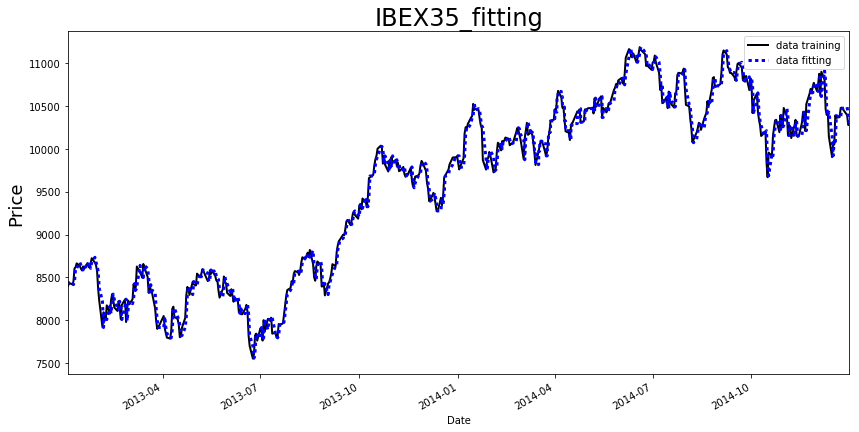

In [18]:
df_train = pd.DataFrame(train_data[1:]['Date'])
df_train['data training'] = pd.Series(train_prices).values
df_train['data fitting'] = pd.Series(fit_prices).values
df_train.index = df_train['Date']
plt.figure(figsize=(14,7))
df_train['data training'].plot(style='k-', linewidth=2, label='data training')
df_train['data fitting'].plot(style='b:', linewidth=3, label='data fitting')
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.title("IBEX35_fitting", fontsize=24)

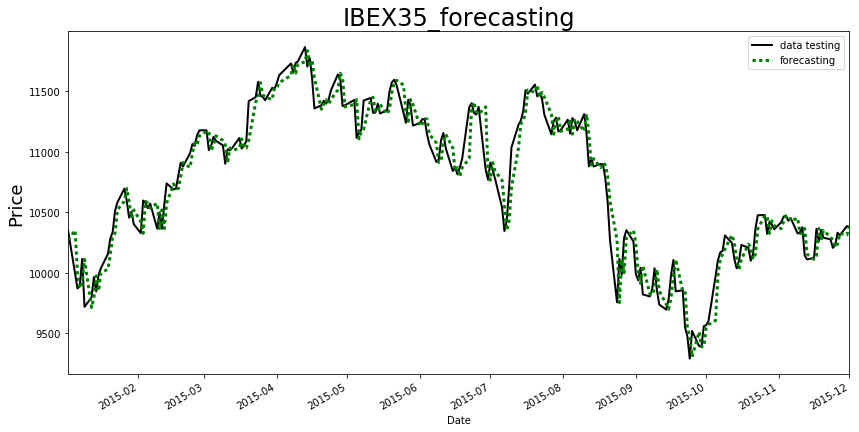

In [19]:
df_test = pd.DataFrame(test_data['Date'])
df_test['data testing'] = pd.Series(actual_prices).values
df_test['forecasting'] = pd.Series(pred_prices).values
df_test.index = df_test['Date']
plt.figure(figsize=(14,7))
df_test['data testing'].plot(style='k-', linewidth=2, label='data testing')
df_test['forecasting'].plot(style='g:', linewidth=3, label='forecasting')
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.title("IBEX35_forecasting", fontsize=24)